In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Dataset Info:
Shape: (200, 5)

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+

In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Basic statistics by gender
print("\nGender Distribution:")
print(df['Gender'].value_counts())

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Gender Distribution:
Gender
Female    112
Male       88
Name: count, dtype: int64


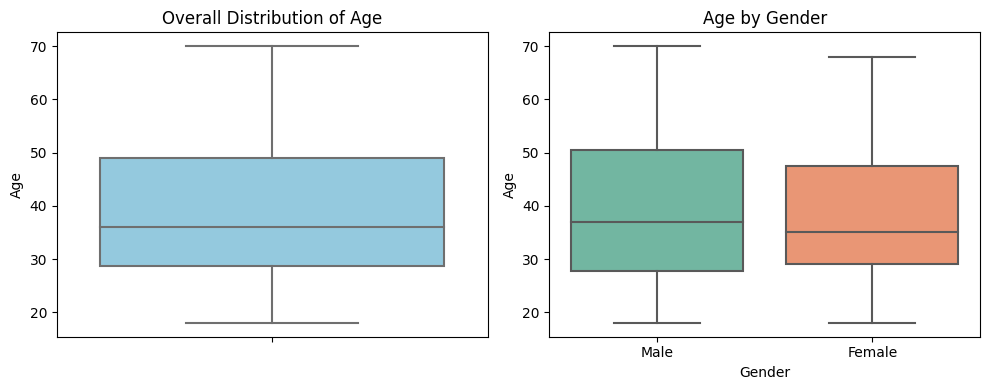

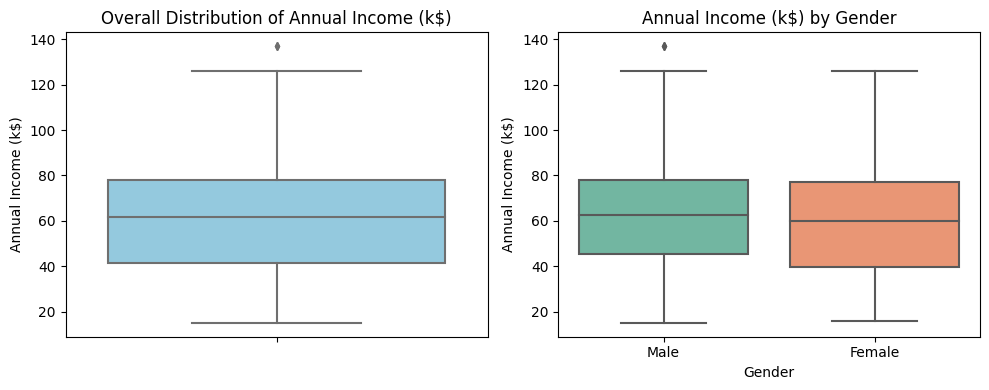

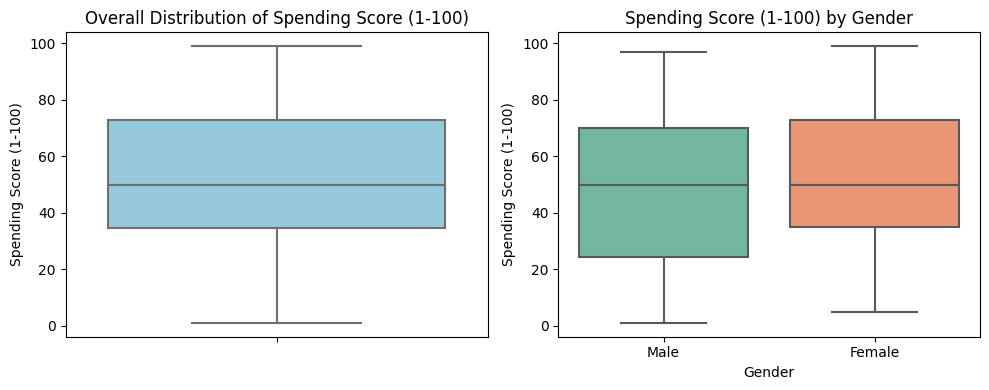

In [5]:
# Select numeric features for analysis
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create individual boxplots for each feature
for feature in numeric_features:
    plt.figure(figsize=(10, 4))
    
    # Overall boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[feature], color='skyblue', fliersize=4)
    plt.title(f'Overall Distribution of {feature}')
    plt.ylabel(feature)
    
    # Boxplot by Gender
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['Gender'], y=df[feature], palette='Set2', fliersize=4)
    plt.title(f'{feature} by Gender')
    plt.xlabel('Gender')
    plt.ylabel(feature)
    
    plt.tight_layout()
    plt.show()

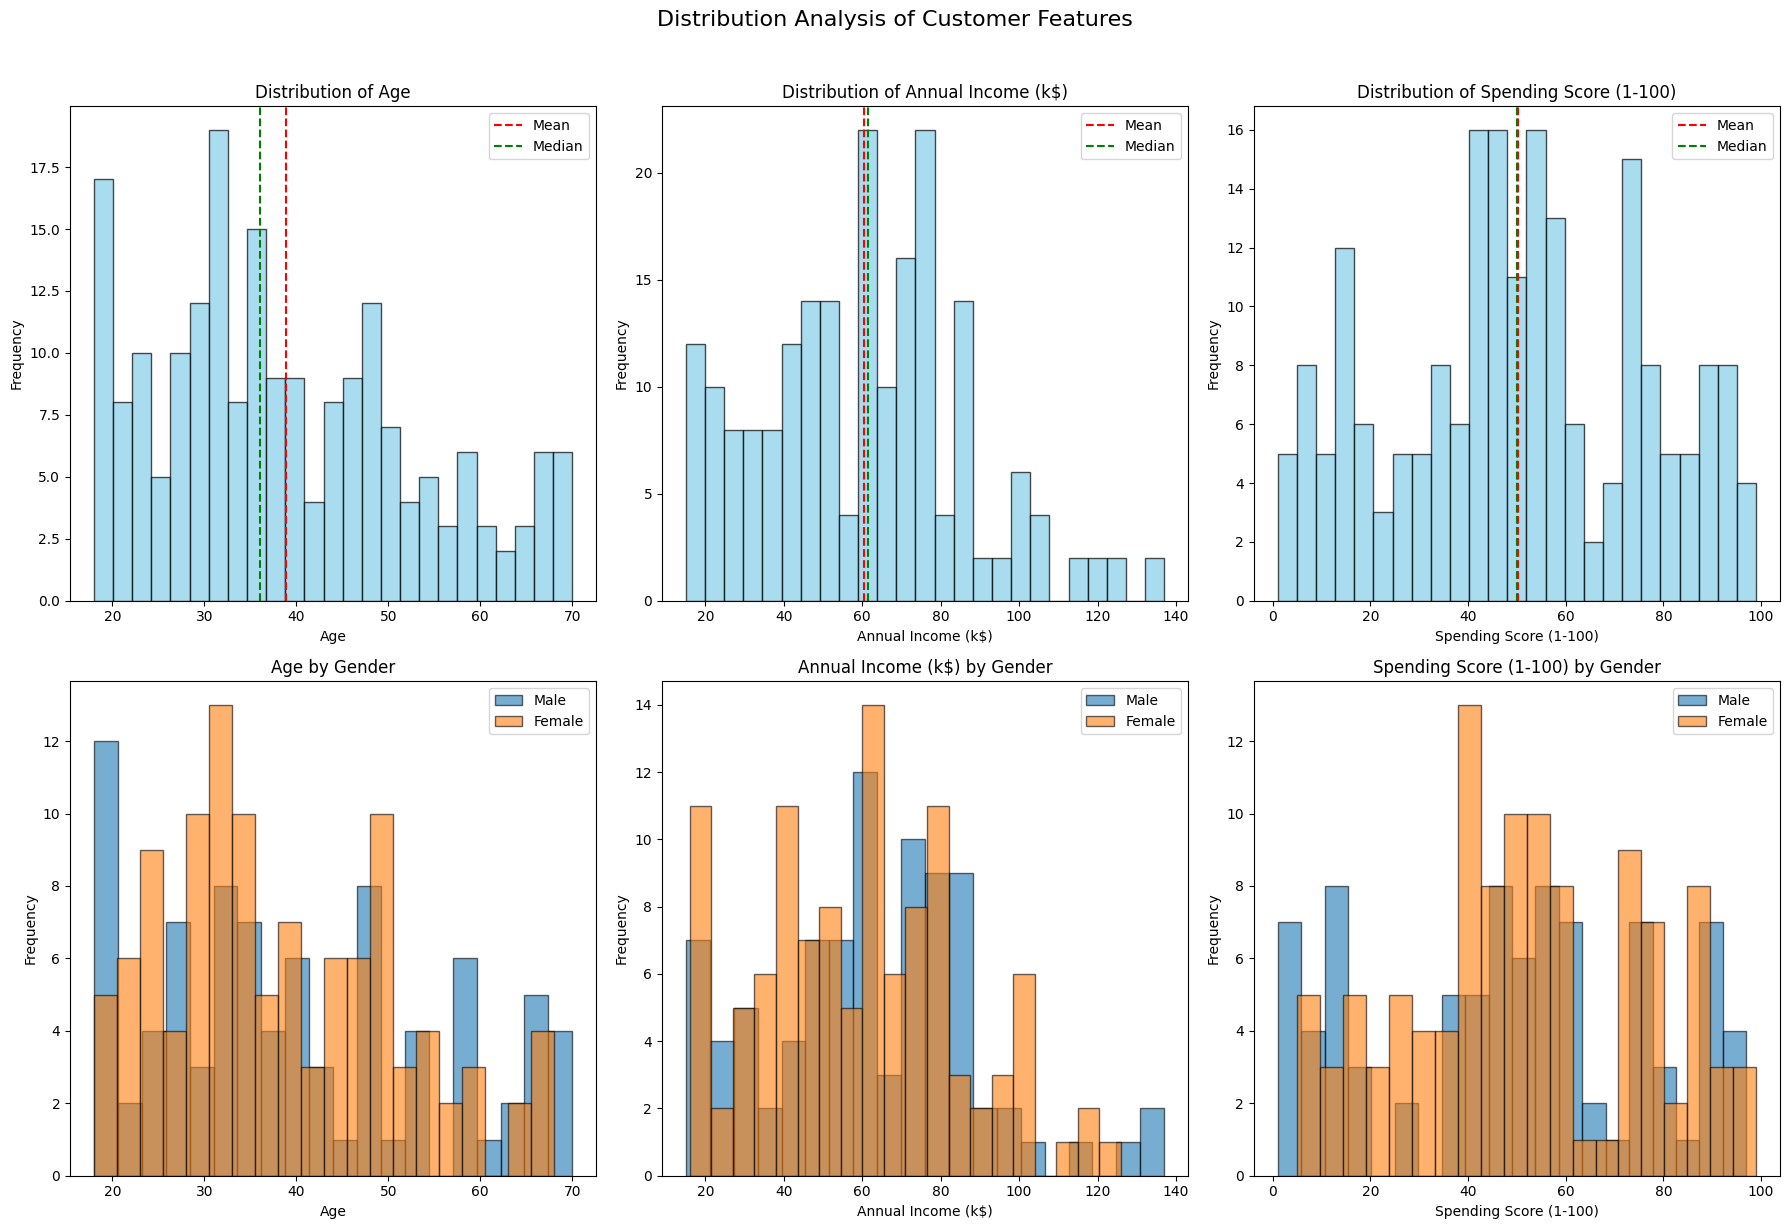

In [6]:
# Create histograms for numeric features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Distribution Analysis of Customer Features", fontsize=16, y=1.02)

for i, feature in enumerate(numeric_features):
    # Overall histogram
    axes[0, i].hist(df[feature], bins=25, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f'Distribution of {feature}')
    axes[0, i].set_xlabel(feature)
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].axvline(df[feature].mean(), color='red', linestyle='--', label='Mean')
    axes[0, i].axvline(df[feature].median(), color='green', linestyle='--', label='Median')
    axes[0, i].legend()
    
    # Distribution by Gender
    for gender in df['Gender'].unique():
        gender_data = df[df['Gender'] == gender][feature]
        axes[1, i].hist(gender_data, bins=20, alpha=0.6, label=gender, edgecolor='black')
    
    axes[1, i].set_title(f'{feature} by Gender')
    axes[1, i].set_xlabel(feature)
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

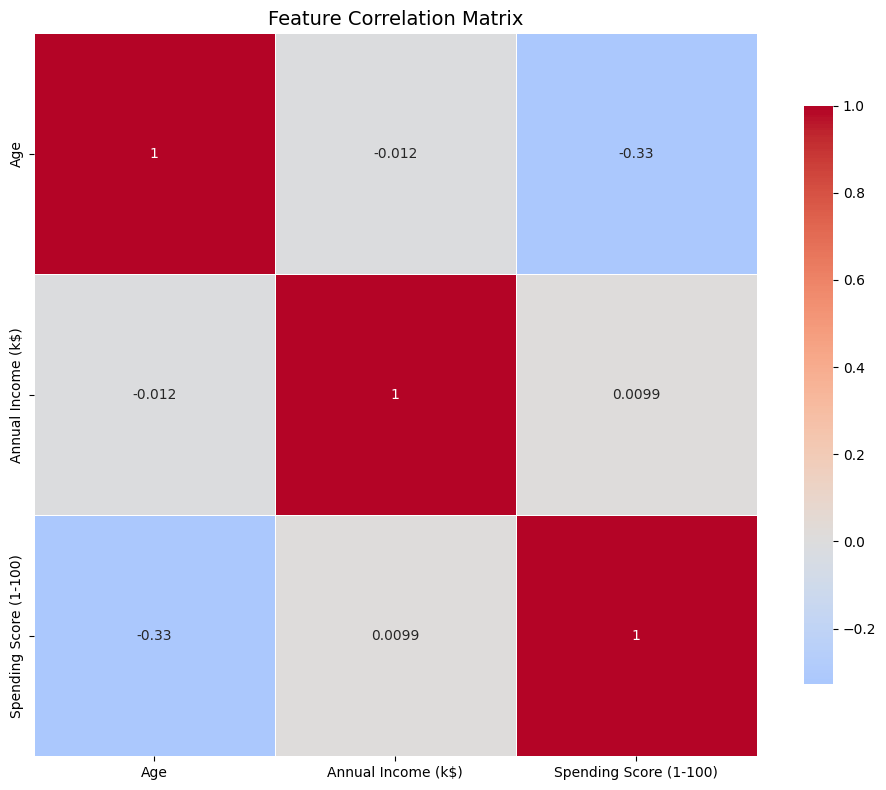

In [7]:
# Create correlation matrix for numeric features
correlation_data = df[numeric_features]
corr_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
# Print correlation values
print("Correlation Analysis:")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        feature1 = corr_matrix.columns[i]
        feature2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        print(f"{feature1} - {feature2}: {corr_value:.3f}")

Correlation Analysis:
Age - Annual Income (k$): -0.012
Age - Spending Score (1-100): -0.327
Annual Income (k$) - Spending Score (1-100): 0.010


<Figure size 1200x1000 with 0 Axes>

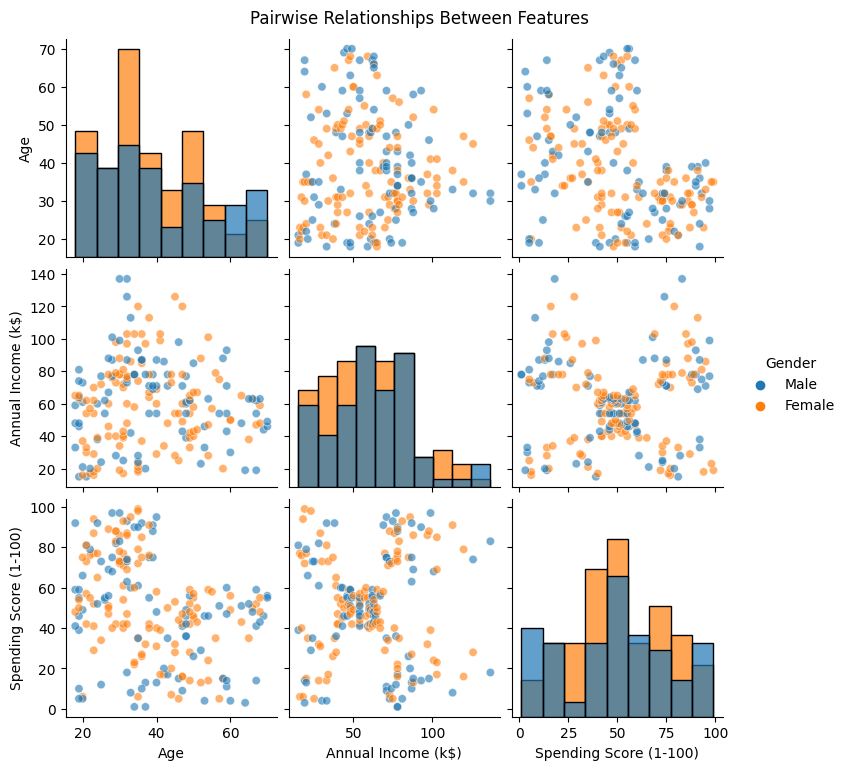

In [9]:
# Create pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(df, vars=numeric_features, hue='Gender', diag_kind='hist', 
             plot_kws={'alpha': 0.6}, diag_kws={'alpha': 0.7})
plt.suptitle("Pairwise Relationships Between Features", y=1.02)
plt.show()

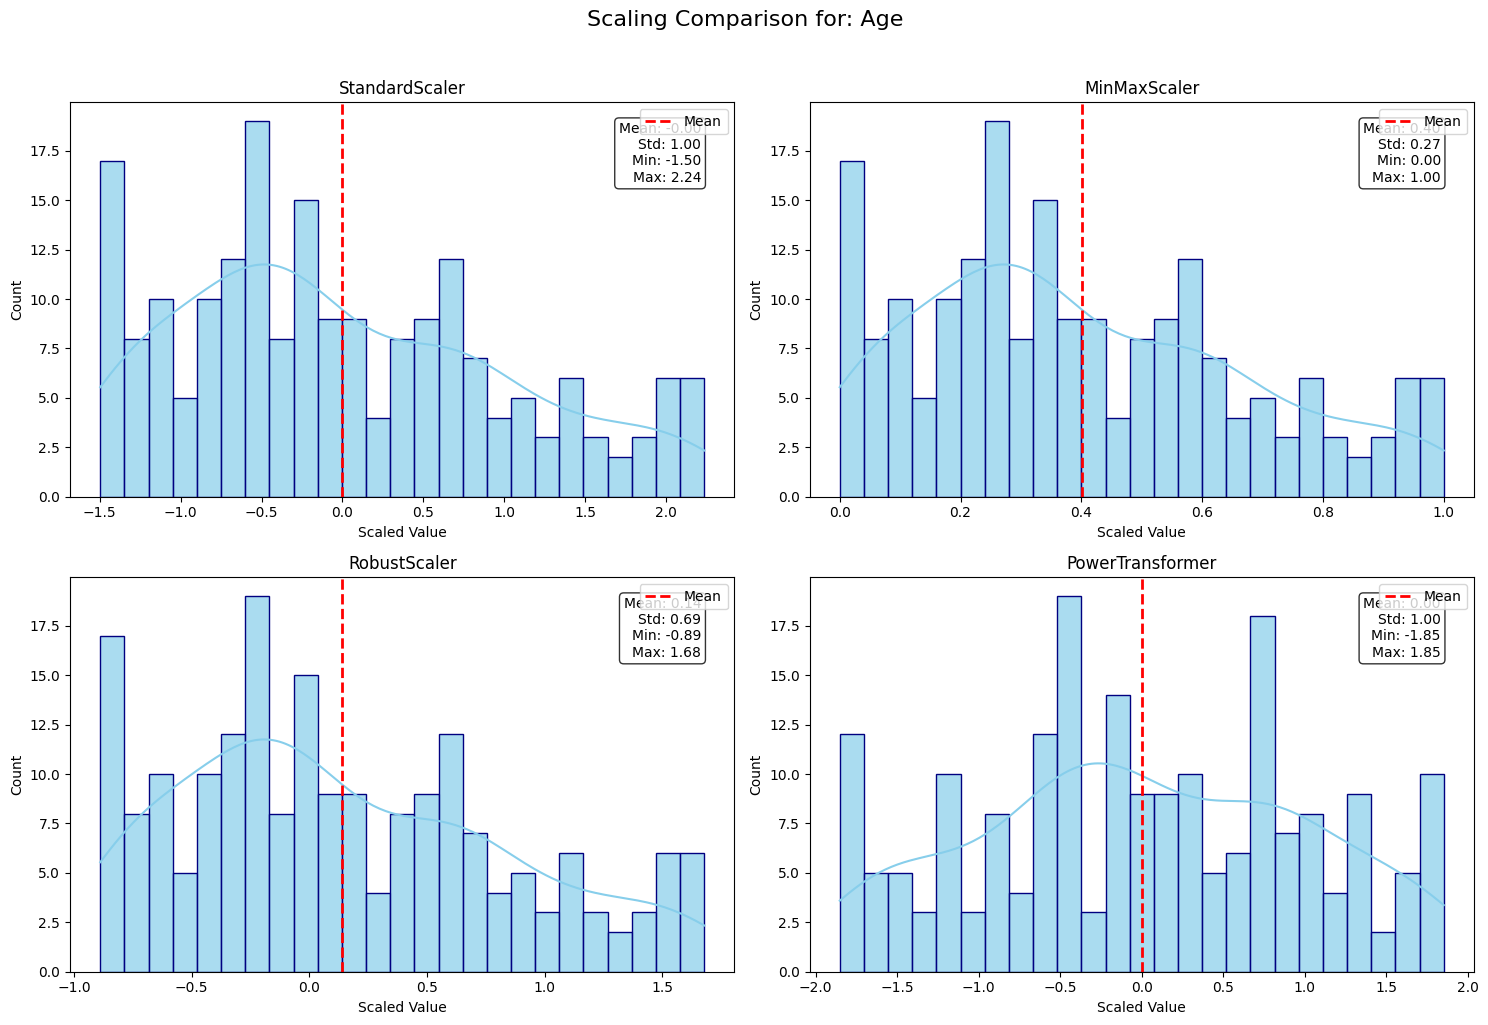

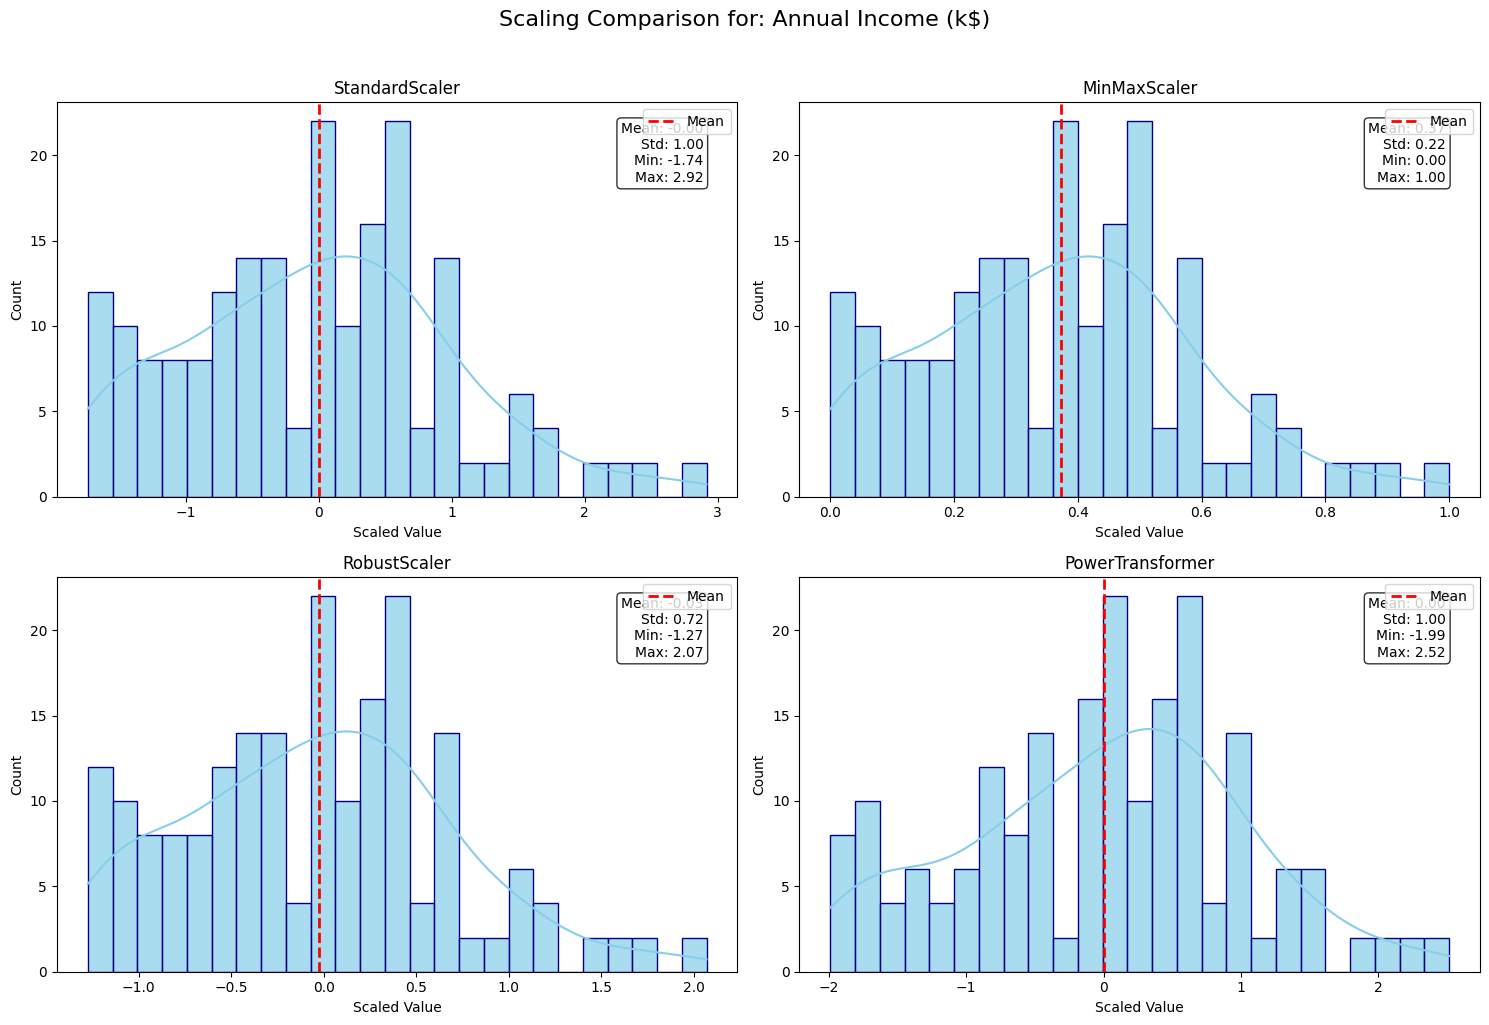

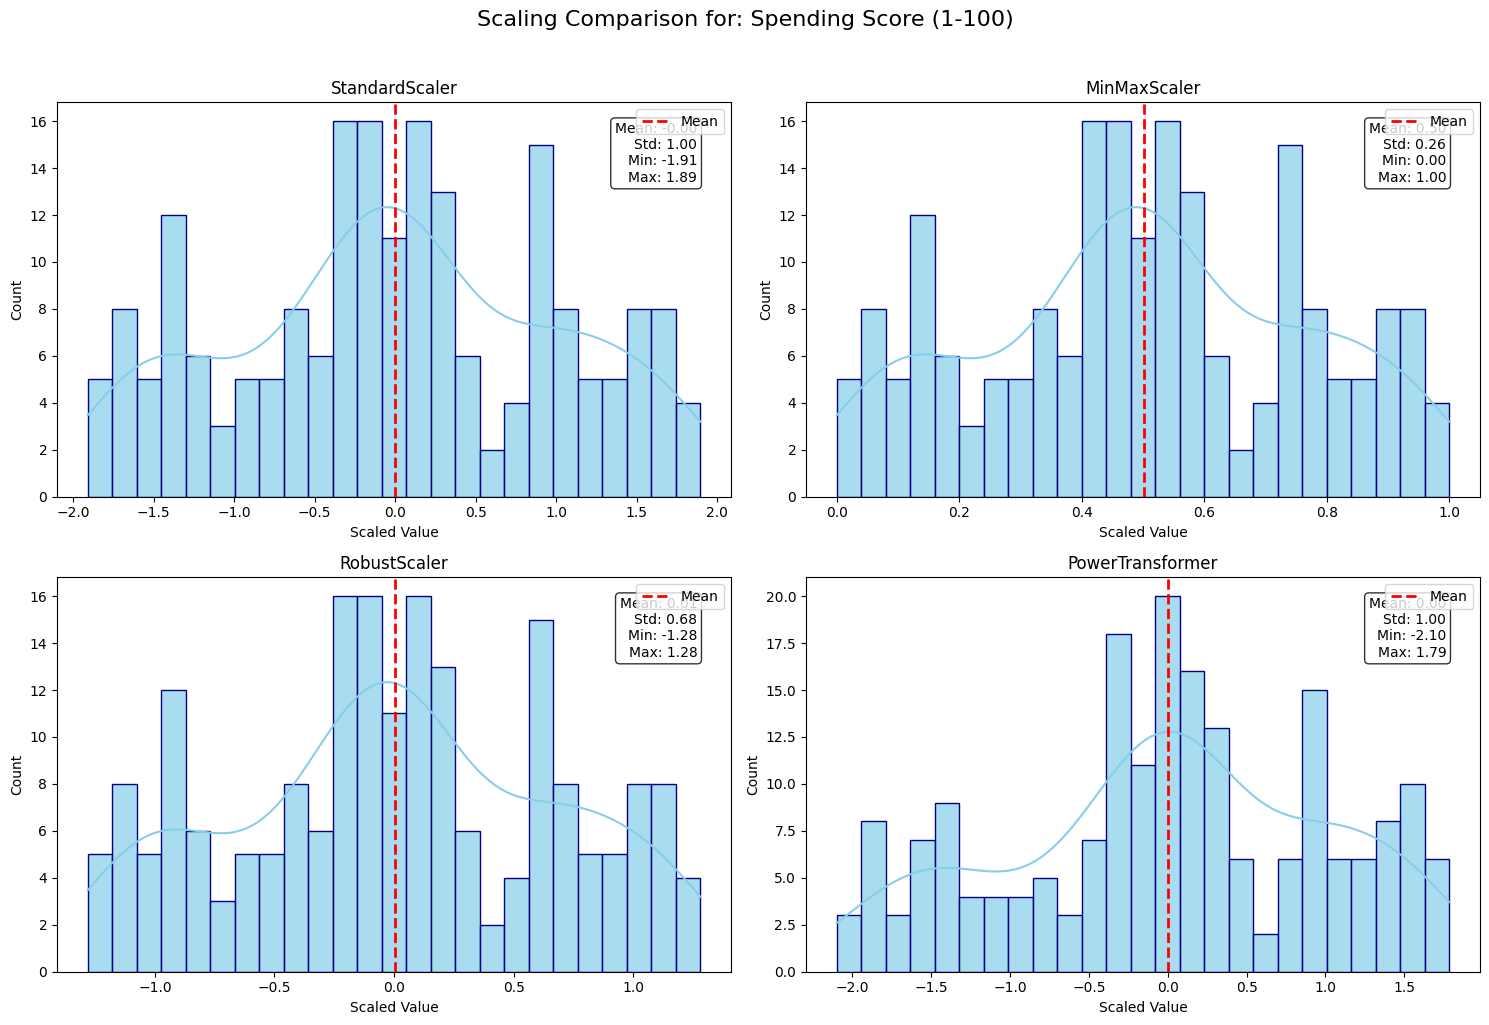

In [10]:
# Prepare features for clustering (excluding CustomerID and Gender)
features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features_for_clustering].copy()

# Compare different scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "PowerTransformer": PowerTransformer(method='yeo-johnson')
}

# Plotting function for scaled distributions
def plot_scaled_distribution(feature, scaler_name, scaler, ax):
    try:
        scaled_data = scaler.fit_transform(X[[feature]])
        df_scaled = pd.DataFrame(scaled_data, columns=[feature])
        
        sns.histplot(data=df_scaled, x=feature, bins=25, kde=True,
                    color='skyblue', edgecolor='navy', ax=ax, alpha=0.7)
        
        mean_val = df_scaled[feature].mean()
        std_val = df_scaled[feature].std()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
        
        stats_text = (f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}\n"
                     f"Min: {df_scaled[feature].min():.2f}\nMax: {df_scaled[feature].max():.2f}")
        
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
               ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
        
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center',
               bbox=dict(facecolor='red', alpha=0.3))
    
    ax.set_title(f'{scaler_name}', fontsize=12)
    ax.set_xlabel('Scaled Value')
    ax.legend()

# Compare scaling methods for each feature
for feature in features_for_clustering:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Scaling Comparison for: {feature}', fontsize=16, y=1.02)
    
    axes = axes.flatten()
    for i, (name, scaler) in enumerate(scalers.items()):
        plot_scaled_distribution(feature, name, scaler, axes[i])
    
    plt.tight_layout()
    plt.show()

In [11]:
# Use StandardScaler for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

# Elbow Method for K-Means
def plot_elbow_method(X_data, max_k=15):
    K = range(1, max_k + 1)
    distortions = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(15, 5))
    
    # Elbow plot
    plt.subplot(1, 3, 1)
    plt.plot(K, distortions, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('K-Means: Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    
    # Calculate elbow point (approximate)
    deltas = np.diff(distortions)
    second_deltas = np.diff(deltas)
    elbow_k = np.argmax(second_deltas) + 2
    plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'Elbow at k={elbow_k}')
    plt.legend()
    
    return distortions, elbow_k

# Silhouette Analysis for K-Means
def plot_silhouette_analysis(X_data, max_k=15):
    K = range(2, max_k + 1)
    silhouette_scores = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_data)
        silhouette_avg = silhouette_score(X_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.subplot(1, 3, 2)
    plt.plot(K, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('K-Means: Silhouette Analysis')
    plt.grid(True, alpha=0.3)
    
    optimal_k = K[np.argmax(silhouette_scores)]
    plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Best k={optimal_k}')
    plt.legend()
    
    return silhouette_scores, optimal_k

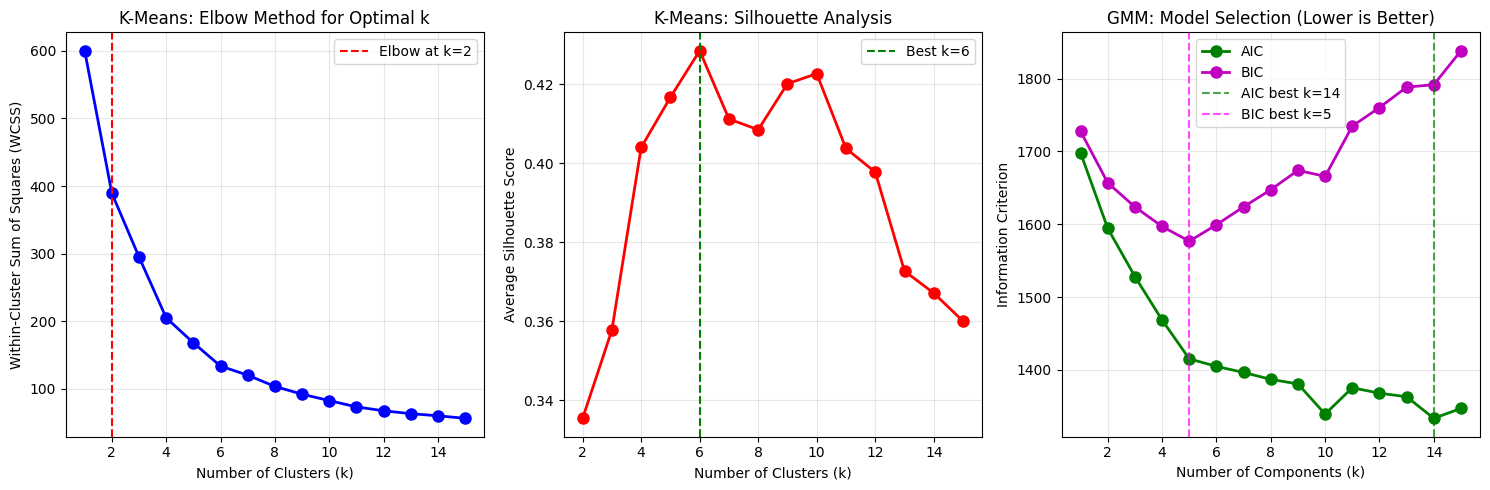

K-Means Elbow method suggests k = 2
K-Means Silhouette analysis suggests k = 6
GMM AIC suggests k = 14
GMM BIC suggests k = 5


In [12]:
# GMM Model Selection using Information Criteria
def plot_gmm_selection(X_data, max_k=15):
    K = range(1, max_k + 1)
    aic_scores = []
    bic_scores = []
    
    for k in K:
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        gmm.fit(X_data)
        aic_scores.append(gmm.aic(X_data))
        bic_scores.append(gmm.bic(X_data))
    
    plt.subplot(1, 3, 3)
    plt.plot(K, aic_scores, 'go-', linewidth=2, markersize=8, label='AIC')
    plt.plot(K, bic_scores, 'mo-', linewidth=2, markersize=8, label='BIC')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Information Criterion')
    plt.title('GMM: Model Selection (Lower is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Find optimal k for both criteria
    aic_optimal_k = K[np.argmin(aic_scores)]
    bic_optimal_k = K[np.argmin(bic_scores)]
    
    plt.axvline(x=aic_optimal_k, color='green', linestyle='--', alpha=0.7, label=f'AIC best k={aic_optimal_k}')
    plt.axvline(x=bic_optimal_k, color='magenta', linestyle='--', alpha=0.7, label=f'BIC best k={bic_optimal_k}')
    plt.legend()
    
    return aic_scores, bic_scores, aic_optimal_k, bic_optimal_k

distortions, elbow_k = plot_elbow_method(X_scaled)
silhouette_scores, silhouette_optimal_k = plot_silhouette_analysis(X_scaled)
aic_scores, bic_scores, aic_optimal_k, bic_optimal_k = plot_gmm_selection(X_scaled)

plt.tight_layout()
plt.show()

print(f"K-Means Elbow method suggests k = {elbow_k}")
print(f"K-Means Silhouette analysis suggests k = {silhouette_optimal_k}")
print(f"GMM AIC suggests k = {aic_optimal_k}")
print(f"GMM BIC suggests k = {bic_optimal_k}")

In [13]:
# Use the optimal number of clusters
optimal_clusters_kmeans = silhouette_optimal_k if silhouette_optimal_k > 2 else 5

print(f"Implementing K-Means with {optimal_clusters_kmeans} clusters...")

# Fit K-Means
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_kmeans = df.copy()
df_kmeans['Cluster'] = kmeans_labels

# Calculate cluster metrics for K-Means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nK-Means Clustering Metrics:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.4f}")
print(f"Davies-Bouldin Score: {kmeans_davies:.4f}")

Implementing K-Means with 6 clusters...

K-Means Clustering Metrics:
Silhouette Score: 0.4284
Calinski-Harabasz Score: 135.1021
Davies-Bouldin Score: 0.8254


In [14]:
# Use BIC optimal for GMM (more conservative, typically better for model selection)
optimal_clusters_gmm = bic_optimal_k if bic_optimal_k > 1 else aic_optimal_k

print(f"Implementing Gaussian Mixture Model with {optimal_clusters_gmm} components...")

# Fit GMM
gmm = GaussianMixture(n_components=optimal_clusters_gmm, random_state=42, n_init=10, 
                      covariance_type='full')  # full covariance allows elliptical clusters
gmm.fit(X_scaled)

# Get hard cluster assignments
gmm_labels = gmm.predict(X_scaled)

# Get soft cluster assignments (probabilities)
gmm_probabilities = gmm.predict_proba(X_scaled)

# Add GMM results to dataframe
df_gmm = df.copy()
df_gmm['Cluster'] = gmm_labels
df_gmm['Max_Probability'] = np.max(gmm_probabilities, axis=1)

# Calculate cluster metrics for GMM
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)
gmm_calinski = calinski_harabasz_score(X_scaled, gmm_labels)
gmm_davies = davies_bouldin_score(X_scaled, gmm_labels)

print(f"\nGMM Clustering Metrics:")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"Calinski-Harabasz Score: {gmm_calinski:.4f}")
print(f"Davies-Bouldin Score: {gmm_davies:.4f}")
print(f"AIC: {gmm.aic(X_scaled):.2f}")
print(f"BIC: {gmm.bic(X_scaled):.2f}")
print(f"Log-Likelihood: {gmm.score(X_scaled):.2f}")

Implementing Gaussian Mixture Model with 5 components...

GMM Clustering Metrics:
Silhouette Score: 0.4064
Calinski-Harabasz Score: 116.9009
Davies-Bouldin Score: 0.9356
AIC: 1415.09
BIC: 1576.71
Log-Likelihood: -3.29


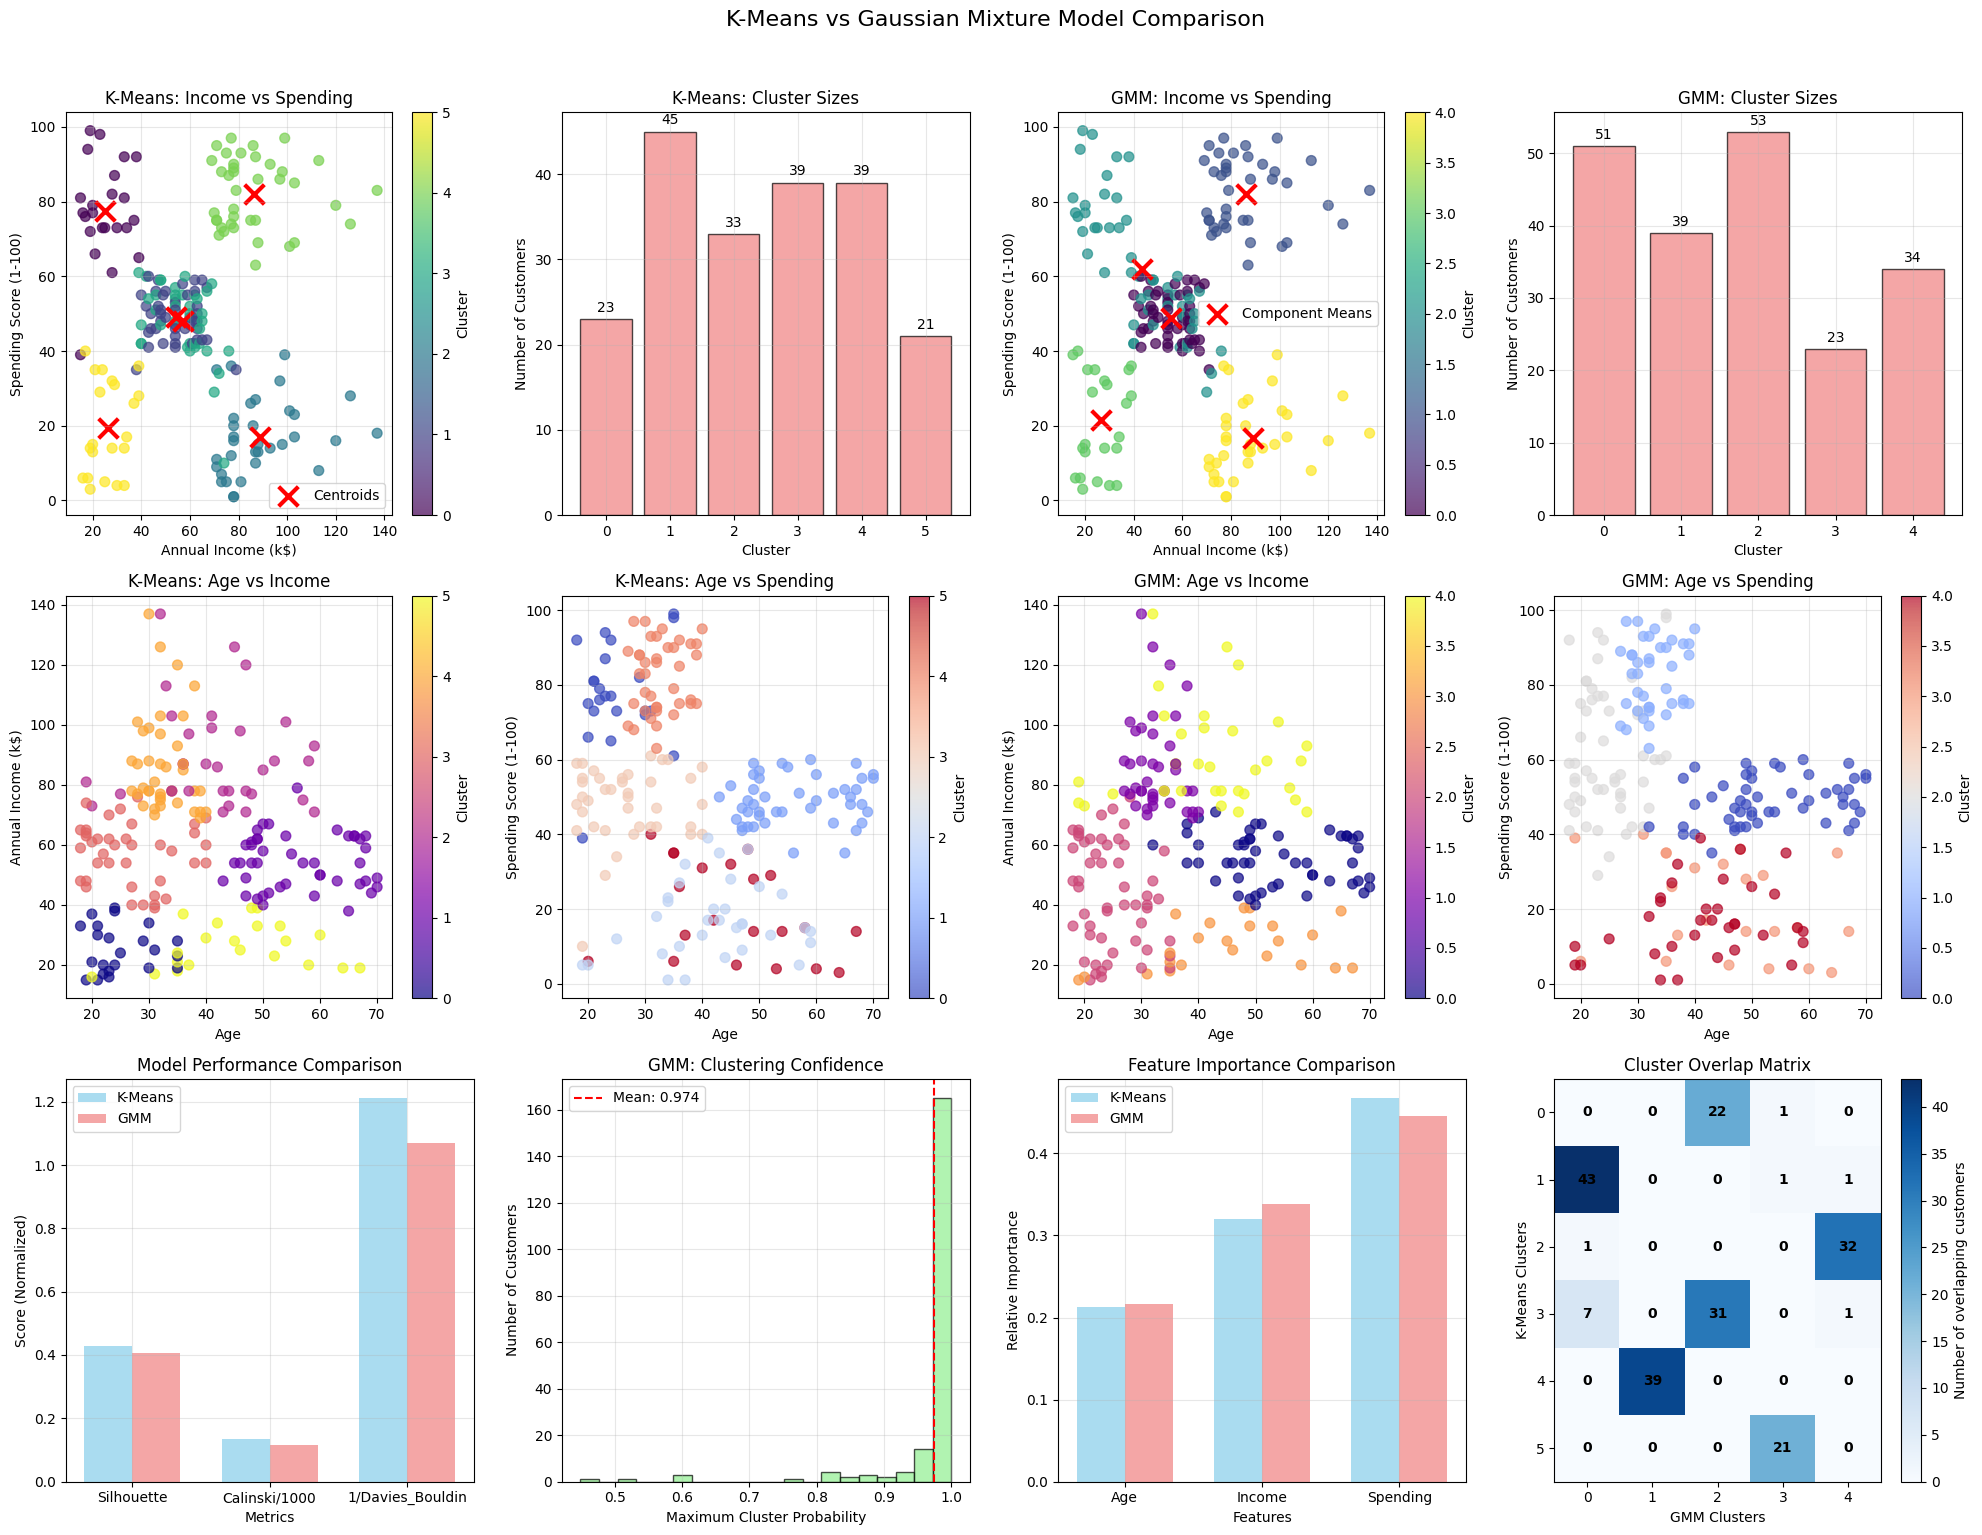

In [15]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('K-Means vs Gaussian Mixture Model Comparison', fontsize=16, y=1.02)

# Income vs Spending plots
for i, (model_name, df_model, labels) in enumerate([
    ('K-Means', df_kmeans, kmeans_labels), 
    ('GMM', df_gmm, gmm_labels)
]):
    
    # Main scatter plot
    ax = axes[0, i*2]
    scatter = ax.scatter(df_model['Annual Income (k$)'], df_model['Spending Score (1-100)'], 
                        c=df_model['Cluster'], cmap='viridis', alpha=0.7, s=50)
    ax.set_xlabel('Annual Income (k$)')
    ax.set_ylabel('Spending Score (1-100)')
    ax.set_title(f'{model_name}: Income vs Spending')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    
    # Add centroids for K-Means or means for GMM
    if model_name == 'K-Means':
        centroids = scaler.inverse_transform(kmeans.cluster_centers_)
        ax.scatter(centroids[:, 1], centroids[:, 2], c='red', marker='x', 
                  s=200, linewidths=3, label='Centroids')
    else:
        # For GMM, show the means of each component
        gmm_means = scaler.inverse_transform(gmm.means_)
        ax.scatter(gmm_means[:, 1], gmm_means[:, 2], c='red', marker='x', 
                  s=200, linewidths=3, label='Component Means')
    ax.legend()
    
    # Cluster size distribution
    ax = axes[0, i*2+1]
    cluster_counts = df_model['Cluster'].value_counts().sort_index()
    bars = ax.bar(cluster_counts.index, cluster_counts.values, 
                  color='lightcoral', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Customers')
    ax.set_title(f'{model_name}: Cluster Sizes')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

# Age vs Income plots
for i, (model_name, df_model) in enumerate([('K-Means', df_kmeans), ('GMM', df_gmm)]):
    ax = axes[1, i*2]
    scatter = ax.scatter(df_model['Age'], df_model['Annual Income (k$)'], 
                        c=df_model['Cluster'], cmap='plasma', alpha=0.7, s=50)
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income (k$)')
    ax.set_title(f'{model_name}: Age vs Income')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')

# Age vs Spending plots
for i, (model_name, df_model) in enumerate([('K-Means', df_kmeans), ('GMM', df_gmm)]):
    ax = axes[1, i*2+1]
    scatter = ax.scatter(df_model['Age'], df_model['Spending Score (1-100)'], 
                        c=df_model['Cluster'], cmap='coolwarm', alpha=0.7, s=50)
    ax.set_xlabel('Age')
    ax.set_ylabel('Spending Score (1-100)')
    ax.set_title(f'{model_name}: Age vs Spending')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')

# Model metrics comparison
ax = axes[2, 0]
metrics = ['Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin']
kmeans_scores = [kmeans_silhouette, kmeans_calinski/1000, 1/kmeans_davies]  # Normalize for visualization
gmm_scores = [gmm_silhouette, gmm_calinski/1000, 1/gmm_davies]  # Higher is better for all

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, kmeans_scores, width, label='K-Means', alpha=0.7, color='skyblue')
ax.bar(x + width/2, gmm_scores, width, label='GMM', alpha=0.7, color='lightcoral')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score (Normalized)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['Silhouette', 'Calinski/1000', '1/Davies_Bouldin'])
ax.legend()
ax.grid(True, alpha=0.3)

# GMM Uncertainty Analysis (unique to GMM)
ax = axes[2, 1]
ax.hist(df_gmm['Max_Probability'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
ax.set_xlabel('Maximum Cluster Probability')
ax.set_ylabel('Number of Customers')
ax.set_title('GMM: Clustering Confidence')
ax.grid(True, alpha=0.3)
ax.axvline(df_gmm['Max_Probability'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df_gmm["Max_Probability"].mean():.3f}')
ax.legend()

# Feature importance comparison (for both models)
ax = axes[2, 2]
feature_names = ['Age', 'Income', 'Spending']

# For K-Means, calculate feature variance within clusters
kmeans_feature_importance = []
for i in range(X_scaled.shape[1]):
    feature_var = 0
    for cluster in range(optimal_clusters_kmeans):
        cluster_data = X_scaled[kmeans_labels == cluster, i]
        if len(cluster_data) > 1:
            feature_var += np.var(cluster_data) * len(cluster_data)
    kmeans_feature_importance.append(1 / (feature_var / len(X_scaled) + 1e-8))

# For GMM, use the average covariance diagonal
gmm_feature_importance = []
avg_covariance = np.mean(gmm.covariances_, axis=0)
for i in range(X_scaled.shape[1]):
    gmm_feature_importance.append(1 / (avg_covariance[i, i] + 1e-8))

# Normalize both
kmeans_feature_importance = np.array(kmeans_feature_importance) / np.sum(kmeans_feature_importance)
gmm_feature_importance = np.array(gmm_feature_importance) / np.sum(gmm_feature_importance)

x = np.arange(len(feature_names))
ax.bar(x - width/2, kmeans_feature_importance, width, label='K-Means', alpha=0.7, color='skyblue')
ax.bar(x + width/2, gmm_feature_importance, width, label='GMM', alpha=0.7, color='lightcoral')

ax.set_xlabel('Features')
ax.set_ylabel('Relative Importance')
ax.set_title('Feature Importance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend()
ax.grid(True, alpha=0.3)

# Cluster overlap analysis
ax = axes[2, 3]
overlap_matrix = np.zeros((max(optimal_clusters_kmeans, optimal_clusters_gmm), 
                          max(optimal_clusters_kmeans, optimal_clusters_gmm)))

# Calculate overlap between K-Means and GMM clusters
for i in range(optimal_clusters_kmeans):
    for j in range(optimal_clusters_gmm):
        overlap = np.sum((kmeans_labels == i) & (gmm_labels == j))
        overlap_matrix[i, j] = overlap

im = ax.imshow(overlap_matrix[:optimal_clusters_kmeans, :optimal_clusters_gmm], 
               cmap='Blues', aspect='auto')
ax.set_xlabel('GMM Clusters')
ax.set_ylabel('K-Means Clusters')
ax.set_title('Cluster Overlap Matrix')

# Add text annotations
for i in range(optimal_clusters_kmeans):
    for j in range(optimal_clusters_gmm):
        text = ax.text(j, i, f'{int(overlap_matrix[i, j])}',
                      ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax, label='Number of overlapping customers')

plt.tight_layout()
plt.show()

In [16]:
print("\n" + "="*80)
print("DETAILED CLUSTER ANALYSIS")
print("="*80)

# K-Means Cluster Profiling
print("\nK-MEANS CLUSTER PROFILING:")
print("-"*50)

kmeans_cluster_summary = df_kmeans.groupby('Cluster')[features_for_clustering].agg(['mean', 'std']).round(2)
print("K-Means Statistical Summary:")
print(kmeans_cluster_summary)

for cluster in sorted(df_kmeans['Cluster'].unique()):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == cluster]
    print(f"\nK-Means Cluster {cluster} Profile:")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_kmeans)*100:.1f}%)")
    print(f"Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"Average Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Average Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}/100")
    print(f"Gender Distribution: {cluster_data['Gender'].value_counts().to_dict()}")

# GMM Cluster Profiling
print("\n\nGAUSSIAN MIXTURE MODEL CLUSTER PROFILING:")
print("-"*50)

gmm_cluster_summary = df_gmm.groupby('Cluster')[features_for_clustering].agg(['mean', 'std']).round(2)
print("GMM Statistical Summary:")
print(gmm_cluster_summary)

for cluster in sorted(df_gmm['Cluster'].unique()):
    cluster_data = df_gmm[df_gmm['Cluster'] == cluster]
    cluster_probabilities = gmm_probabilities[df_gmm['Cluster'] == cluster, cluster]
    
    print(f"\nGMM Cluster {cluster} Profile:")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_gmm)*100:.1f}%)")
    print(f"Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"Average Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Average Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}/100")
    print(f"Average Cluster Probability: {cluster_probabilities.mean():.3f}")
    print(f"Gender Distribution: {cluster_data['Gender'].value_counts().to_dict()}")


DETAILED CLUSTER ANALYSIS

K-MEANS CLUSTER PROFILING:
--------------------------------------------------
K-Means Statistical Summary:
           Age        Annual Income (k$)        Spending Score (1-100)       
          mean    std               mean    std                   mean    std
Cluster                                                                      
0        25.00   5.30              25.26   7.72                  77.61  13.27
1        56.33   8.45              54.27   8.98                  49.07   6.30
2        41.94  10.18              88.94  16.59                  16.97   9.96
3        26.79   7.06              57.10  10.16                  48.13   9.97
4        32.69   3.73              86.54  16.31                  82.13   9.36
5        45.52  11.77              26.29   7.44                  19.38  12.56

K-Means Cluster 0 Profile:
Size: 23 customers (11.5%)
Average Age: 25.0 years
Average Income: $25.3k
Average Spending Score: 77.6/100
Gender Distribution: {'Femal

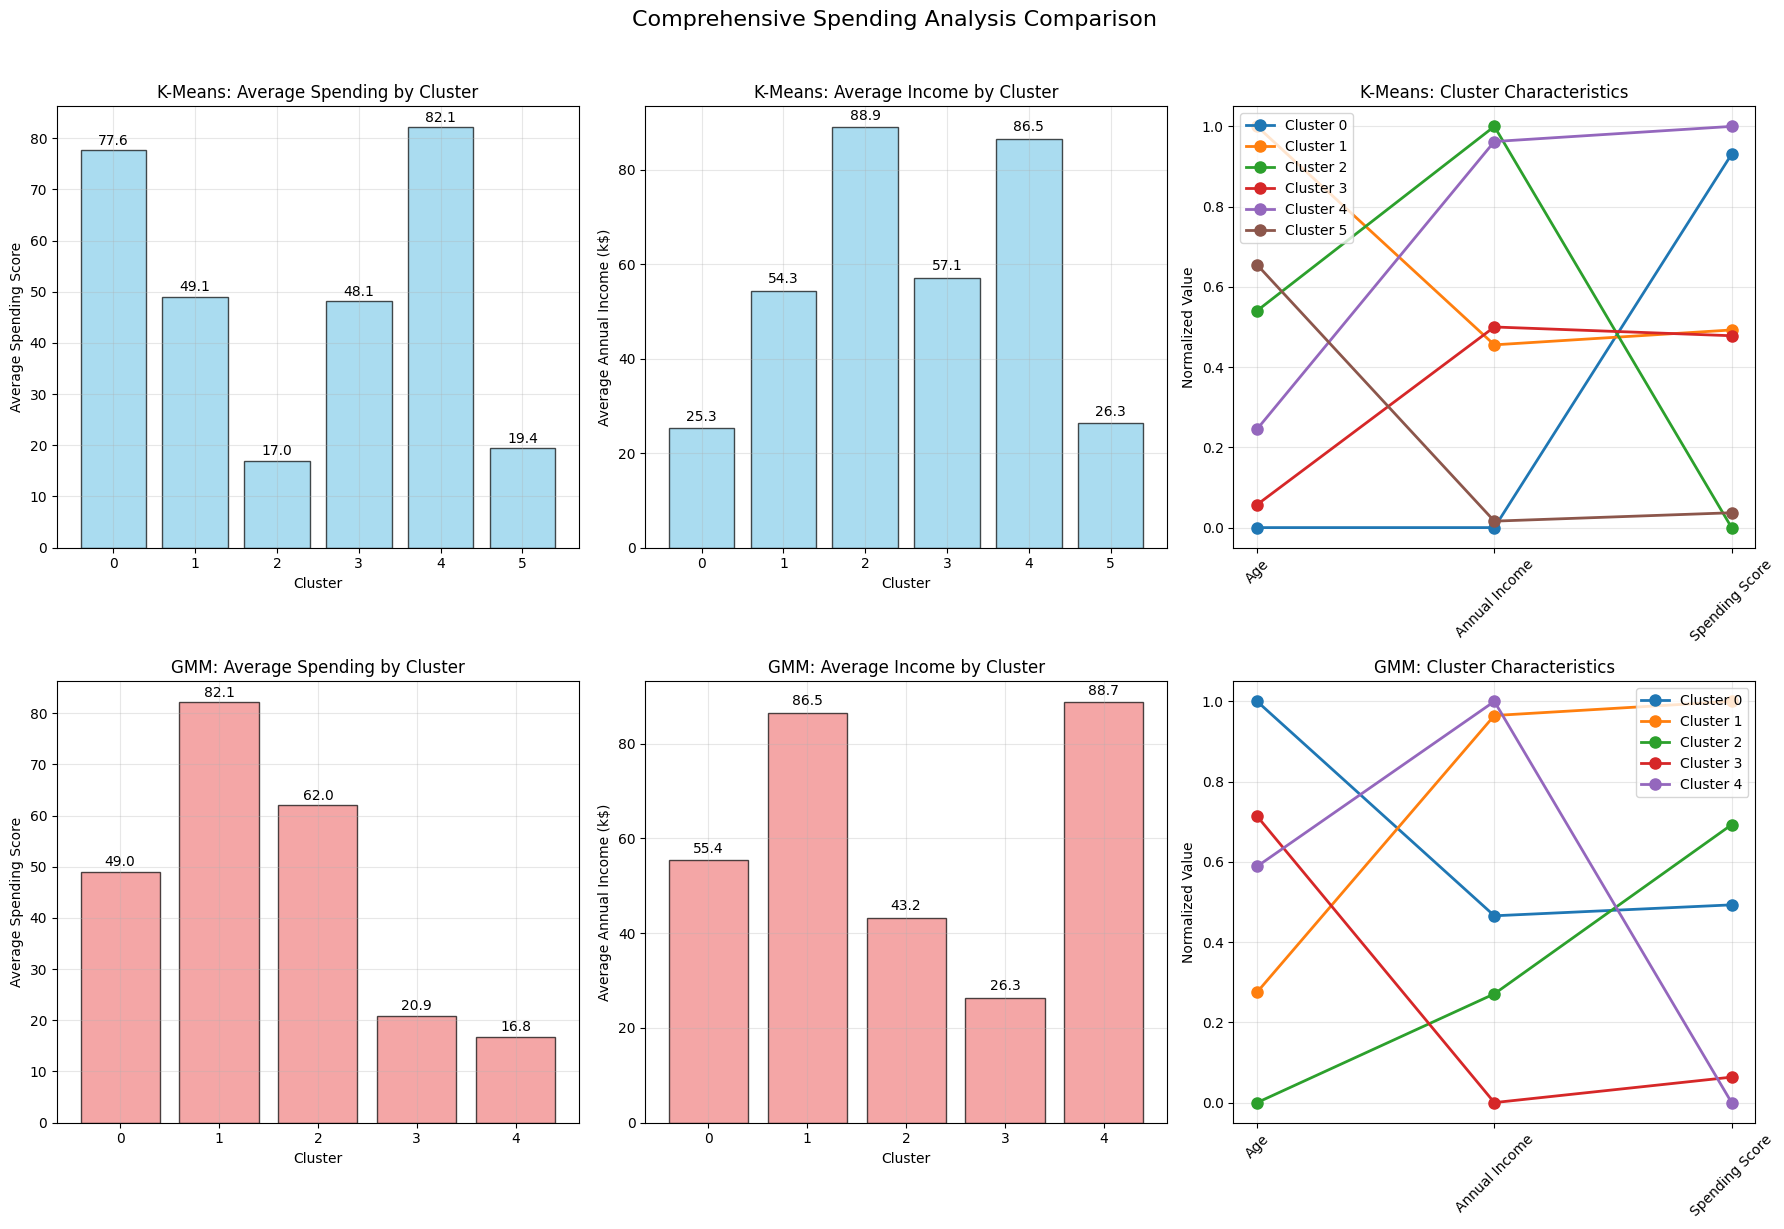

In [17]:
# Compare average spending between models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Spending Analysis Comparison', fontsize=16, y=1.02)

models_data = [
    ('K-Means', df_kmeans, 'skyblue'),
    ('GMM', df_gmm, 'lightcoral')
]

for row, (model_name, df_model, color) in enumerate(models_data):
    # Average spending by cluster
    avg_spending = df_model.groupby('Cluster')['Spending Score (1-100)'].mean().sort_values(ascending=False)
    
    ax = axes[row, 0]
    bars = ax.bar(avg_spending.index, avg_spending.values, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Spending Score')
    ax.set_title(f'{model_name}: Average Spending by Cluster')
    ax.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}', ha='center', va='bottom')
    
    # Average income by cluster
    avg_income = df_model.groupby('Cluster')['Annual Income (k$)'].mean()
    
    ax = axes[row, 1]
    bars = ax.bar(avg_income.index, avg_income.values, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Annual Income (k$)')
    ax.set_title(f'{model_name}: Average Income by Cluster')
    ax.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom')
    
    # Cluster characteristics profile
    ax = axes[row, 2]
    cluster_means = df_model.groupby('Cluster')[features_for_clustering].mean()
    cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    for cluster in cluster_means_norm.index:
        ax.plot(range(len(features_for_clustering)), cluster_means_norm.loc[cluster], 
               marker='o', label=f'Cluster {cluster}', linewidth=2, markersize=8)
    
    ax.set_xticks(range(len(features_for_clustering)))
    ax.set_xticklabels([f.replace(' (k$)', '').replace(' (1-100)', '') for f in features_for_clustering], 
                      rotation=45)
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{model_name}: Cluster Characteristics')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Try different eps values for DBSCAN
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7]

best_dbscan_score = -1
best_dbscan_params = {}
best_dbscan_model = None

# Grid search for DBSCAN parameters
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_scaled)
        
        # Remove noise points for analysis
        mask = dbscan_labels != -1
        unique_clusters = set(dbscan_labels[mask])
        
        # Skip if no clusters found, all points are noise, or only one cluster
        if len(unique_clusters) < 2:
            continue
            
        # Calculate silhouette score (excluding noise points)
        try:
            filtered_data = X_scaled[mask]
            filtered_labels = dbscan_labels[mask]
            
            # Double check we have at least 2 clusters and enough points
            if len(set(filtered_labels)) >= 2 and len(filtered_labels) >= 2:
                score = silhouette_score(filtered_data, filtered_labels)
                if score > best_dbscan_score:
                    best_dbscan_score = score
                    best_dbscan_params = {'eps': eps, 'min_samples': min_samples}
                    best_dbscan_model = dbscan
        except ValueError:
            # Skip this parameter combination if silhouette score fails
            continue

Best DBSCAN parameters: {'eps': 0.5, 'min_samples': 7}
Best DBSCAN silhouette score: 0.5499


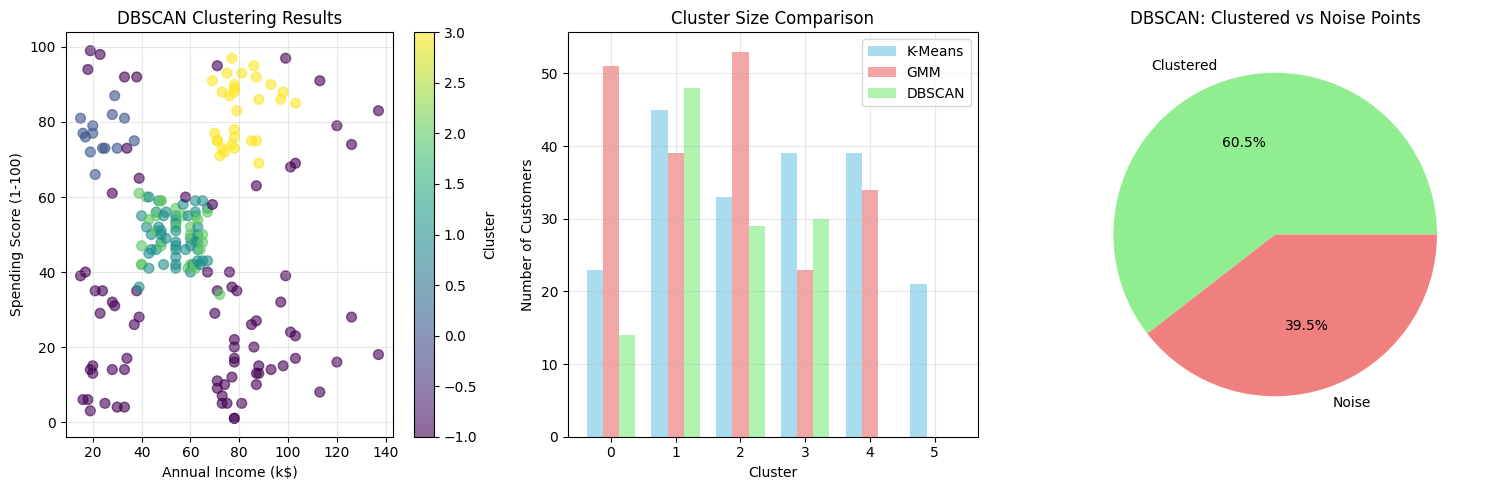

DBSCAN found 4 clusters
Noise points: 79 (39.5%)


In [20]:
if best_dbscan_model is not None:
    print(f"Best DBSCAN parameters: {best_dbscan_params}")
    print(f"Best DBSCAN silhouette score: {best_dbscan_score:.4f}")
    
    # Apply best DBSCAN
    dbscan_labels = best_dbscan_model.fit_predict(X_scaled)
    df_dbscan = df.copy()
    df_dbscan['Cluster'] = dbscan_labels
    
    # Calculate additional metrics for DBSCAN
    mask = dbscan_labels != -1
    if np.sum(mask) > 1 and len(set(dbscan_labels[mask])) > 1:
        dbscan_calinski = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_davies = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_calinski = 0
        dbscan_davies = float('inf')
    
    # Visualize DBSCAN results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(df_dbscan['Annual Income (k$)'], df_dbscan['Spending Score (1-100)'], 
                         c=df_dbscan['Cluster'], cmap='viridis', alpha=0.6, s=50)
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.title('DBSCAN Clustering Results')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    
    # Compare cluster counts
    plt.subplot(1, 3, 2)
    kmeans_counts = df_kmeans['Cluster'].value_counts().sort_index()
    gmm_counts = df_gmm['Cluster'].value_counts().sort_index()
    dbscan_counts = df_dbscan['Cluster'].value_counts().sort_index()
    
    # Handle different cluster ranges
    max_clusters = max(len(kmeans_counts), len(gmm_counts), len(dbscan_counts))
    x = np.arange(max_clusters)
    width = 0.25
    
    # Pad counts with zeros for missing clusters
    kmeans_vals = [kmeans_counts.get(i, 0) for i in range(max_clusters)]
    gmm_vals = [gmm_counts.get(i, 0) for i in range(max_clusters)]
    dbscan_vals = [dbscan_counts.get(i, 0) for i in range(max_clusters)]
    
    plt.bar(x - width, kmeans_vals, width, 
            label='K-Means', alpha=0.7, color='skyblue')
    plt.bar(x, gmm_vals, width, 
            label='GMM', alpha=0.7, color='lightcoral')
    plt.bar(x + width, dbscan_vals, width, 
            label='DBSCAN', alpha=0.7, color='lightgreen')
    
    plt.xlabel('Cluster')
    plt.ylabel('Number of Customers')
    plt.title('Cluster Size Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Noise points analysis
    plt.subplot(1, 3, 3)
    noise_points = np.sum(dbscan_labels == -1)
    regular_points = len(dbscan_labels) - noise_points
    
    if noise_points > 0:
        plt.pie([regular_points, noise_points], labels=['Clustered', 'Noise'], 
                autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
        plt.title('DBSCAN: Clustered vs Noise Points')
    else:
        plt.pie([regular_points], labels=['Clustered'], 
                autopct='%1.1f%%', colors=['lightgreen'])
        plt.title('DBSCAN: All Points Clustered')
    
    plt.tight_layout()
    plt.show()
    
    unique_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"DBSCAN found {unique_clusters} clusters")
    print(f"Noise points: {noise_points} ({noise_points/len(dbscan_labels)*100:.1f}%)")

else:
    print("Could not find suitable DBSCAN parameters for this dataset")
    print("DBSCAN may not be appropriate for this data distribution")
    # Set default values for comparison
    dbscan_calinski = 0
    dbscan_davies = float('inf')
    dbscan_labels = None

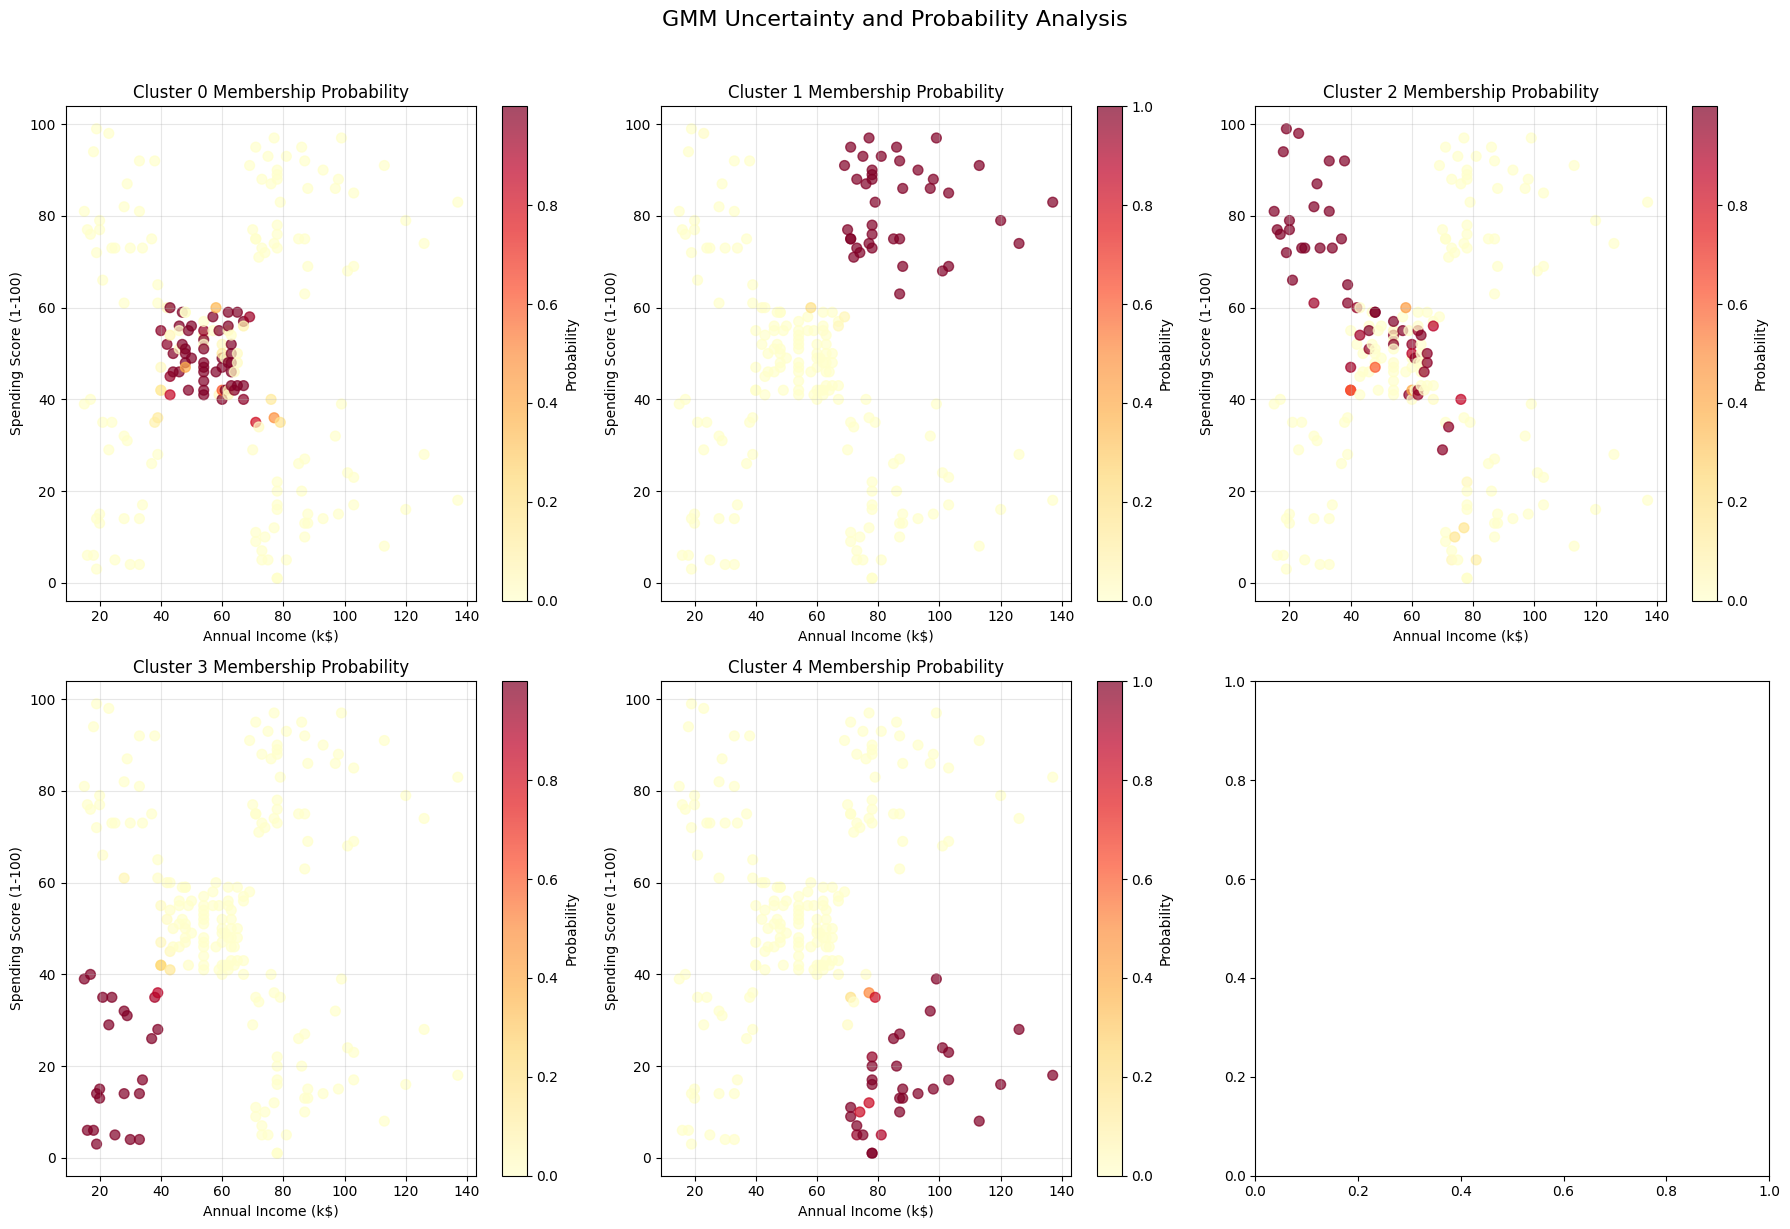


Most Uncertain Customers (GMM):
----------------------------------------
     Age  Annual Income (k$)  Spending Score (1-100)  Cluster  Max_Probability
88    34                  58                      60        2            0.449
146   48                  77                      36        4            0.510
94    32                  60                      42        0            0.603
69    32                  48                      47        2            0.605
49    31                  40                      42        2            0.611
48    29                  40                      42        2            0.752
126   43                  71                      35        0            0.810
160   56                  79                      35        4            0.826
138   19                  74                      10        4            0.833
144   25                  77                      12        4            0.833


In [21]:
# Unique GMM Analysis - Probability Heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GMM Uncertainty and Probability Analysis', fontsize=16, y=1.02)

# Plot probability heatmaps for each cluster
for i in range(min(6, optimal_clusters_gmm)):  # Show up to 6 clusters
    if i < optimal_clusters_gmm:
        row = i // 3
        col = i % 3
        
        # Create probability heatmap
        ax = axes[row, col]
        scatter = ax.scatter(df_gmm['Annual Income (k$)'], df_gmm['Spending Score (1-100)'], 
                           c=gmm_probabilities[:, i], cmap='YlOrRd', alpha=0.7, s=50)
        ax.set_xlabel('Annual Income (k$)')
        ax.set_ylabel('Spending Score (1-100)')
        ax.set_title(f'Cluster {i} Membership Probability')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Probability')
    else:
        # If fewer than 6 clusters, show uncertainty analysis
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Show points with high uncertainty (low max probability)
        uncertainty = 1 - df_gmm['Max_Probability']
        scatter = ax.scatter(df_gmm['Annual Income (k$)'], df_gmm['Spending Score (1-100)'], 
                           c=uncertainty, cmap='Reds', alpha=0.7, s=50)
        ax.set_xlabel('Annual Income (k$)')
        ax.set_ylabel('Spending Score (1-100)')
        ax.set_title('Clustering Uncertainty')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Uncertainty (1-Max Prob)')

plt.tight_layout()
plt.show()

# Find most uncertain customers
print("\nMost Uncertain Customers (GMM):")
print("-"*40)
uncertain_customers = df_gmm.nsmallest(10, 'Max_Probability')
print(uncertain_customers[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 
                          'Cluster', 'Max_Probability']].round(3))

In [22]:
print("\n" + "="*80)
print("MODEL COMPARISON AND RECOMMENDATION")
print("="*80)

# Compare all metrics
models_comparison = {
    'Model': ['K-Means', 'GMM'],
    'Silhouette Score': [kmeans_silhouette, gmm_silhouette],
    'Calinski-Harabasz': [kmeans_calinski, gmm_calinski],
    'Davies-Bouldin': [kmeans_davies, gmm_davies],
    'Number of Clusters': [optimal_clusters_kmeans, optimal_clusters_gmm]
}

# Add DBSCAN results if available
if best_dbscan_model is not None and dbscan_labels is not None:
    models_comparison['Model'].append('DBSCAN')
    models_comparison['Silhouette Score'].append(best_dbscan_score)
    models_comparison['Calinski-Harabasz'].append(dbscan_calinski)
    models_comparison['Davies-Bouldin'].append(dbscan_davies)
    unique_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    models_comparison['Number of Clusters'].append(unique_clusters)

comparison_df = pd.DataFrame(models_comparison)
print("Model Performance Comparison:")
print(comparison_df.round(4))

# Determine best model
best_model_idx = np.argmax(comparison_df['Silhouette Score'])
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\nRECOMMENDED MODEL: {best_model_name}")
print(f"Reasoning: Highest Silhouette Score of {comparison_df.loc[best_model_idx, 'Silhouette Score']:.4f}")

# Business insights based on best model
if best_model_name == 'K-Means':
    df_best = df_kmeans
    model_type = "K-Means"
elif best_model_name == 'GMM':
    df_best = df_gmm
    model_type = "Gaussian Mixture Model"
elif best_model_name == 'DBSCAN' and best_dbscan_model is not None:
    df_best = df_dbscan
    model_type = "DBSCAN"
else:
    # Fallback to GMM if DBSCAN failed
    df_best = df_gmm
    model_type = "Gaussian Mixture Model"
    best_model_name = "GMM"

print(f"\nBUSINESS INSIGHTS ({model_type}):")
print("-"*50)

for cluster in sorted(df_best['Cluster'].unique()):
    if cluster == -1:  # Skip noise points for DBSCAN
        continue
        
    cluster_data = df_best[df_best['Cluster'] == cluster]
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    avg_age = cluster_data['Age'].mean()
    
    # Define customer segment personality
    if avg_income >= 60 and avg_spending >= 60:
        personality = "High Value Customers"
        strategy = "Premium products, loyalty programs, personalized service"
    elif avg_income >= 60 and avg_spending < 40:
        personality = "Conservative High Earners"
        strategy = "Value proposition focus, quality emphasis, exclusive offers"
    elif avg_income < 50 and avg_spending >= 60:
        personality = "Impulsive Spenders"
        strategy = "Limited-time offers, trendy products, payment plans"
    elif avg_income < 50 and avg_spending < 40:
        personality = "Budget-Conscious"
        strategy = "Discounts, bulk deals, basic product lines"
    else:
        personality = "Moderate Customers"
        strategy = "Balanced approach, seasonal promotions, mid-range products"
    
    print(f"\nCluster {cluster}: {personality}")
    print(f"  Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_best)*100:.1f}%)")
    print(f"  Demographics: Avg Age {avg_age:.1f}, Income ${avg_income:.1f}k, Spending {avg_spending:.1f}/100")
    print(f"  Marketing Strategy: {strategy}")


MODEL COMPARISON AND RECOMMENDATION
Model Performance Comparison:
     Model  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  \
0  K-Means            0.4284           135.1021          0.8254   
1      GMM            0.4064           116.9009          0.9356   
2   DBSCAN            0.5499           163.5773          0.5948   

   Number of Clusters  
0                   6  
1                   5  
2                   4  

RECOMMENDED MODEL: DBSCAN
Reasoning: Highest Silhouette Score of 0.5499

BUSINESS INSIGHTS (DBSCAN):
--------------------------------------------------

Cluster 0: Impulsive Spenders
  Size: 14 customers (7.0%)
  Demographics: Avg Age 23.7, Income $23.9k, Spending 76.6/100
  Marketing Strategy: Limited-time offers, trendy products, payment plans

Cluster 1: Moderate Customers
  Size: 48 customers (24.0%)
  Demographics: Avg Age 54.5, Income $54.1k, Spending 49.1/100
  Marketing Strategy: Balanced approach, seasonal promotions, mid-range products

Cluster 2: Mod

In [23]:
print("\n" + "="*80)
print("CUSTOMER SEGMENTATION ANALYSIS SUMMARY")
print("="*80)

print(f"\nDataset: Mall Customers")
print(f"Total Customers: {len(df)}")
print(f"Features Used: {', '.join(features_for_clustering)}")

print(f"\nModel Performance Comparison:")
for i, row in comparison_df.iterrows():
    print(f"{row['Model']}:")
    print(f"  Clusters: {int(row['Number of Clusters'])}")
    print(f"  Silhouette Score: {row['Silhouette Score']:.4f}")
    print(f"  Calinski-Harabasz: {row['Calinski-Harabasz']:.2f}")
    print(f"  Davies-Bouldin: {row['Davies-Bouldin']:.4f}")

print(f"\nRECOMMENDED APPROACH: {best_model_name}")

if best_model_name == 'GMM':
    print("GMM Advantages for this dataset:")
    print("- Provides soft clustering with membership probabilities")
    print("- Handles overlapping customer segments naturally")
    print("- Captures elliptical cluster shapes better than K-means")
    print("- Offers uncertainty quantification for borderline customers")
    print(f"- Model selection via AIC ({gmm.aic(X_scaled):.2f}) and BIC ({gmm.bic(X_scaled):.2f})")

print(f"\nKey Business Segments Identified:")
segment_summary = df_best.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean', 
    'Spending Score (1-100)': 'mean'
}).round(1)

for cluster in segment_summary.index:
    if cluster == -1:
        continue
    row = segment_summary.loc[cluster]
    size = len(df_best[df_best['Cluster'] == cluster])
    print(f"  Segment {cluster}: {size} customers - Age: {row['Age']}, Income: ${row['Annual Income (k$)']}k, Spending: {row['Spending Score (1-100)']}")

print("\n" + "="*80)


CUSTOMER SEGMENTATION ANALYSIS SUMMARY

Dataset: Mall Customers
Total Customers: 200
Features Used: Age, Annual Income (k$), Spending Score (1-100)

Model Performance Comparison:
K-Means:
  Clusters: 6
  Silhouette Score: 0.4284
  Calinski-Harabasz: 135.10
  Davies-Bouldin: 0.8254
GMM:
  Clusters: 5
  Silhouette Score: 0.4064
  Calinski-Harabasz: 116.90
  Davies-Bouldin: 0.9356
DBSCAN:
  Clusters: 4
  Silhouette Score: 0.5499
  Calinski-Harabasz: 163.58
  Davies-Bouldin: 0.5948

RECOMMENDED APPROACH: DBSCAN

Key Business Segments Identified:
  Segment 0: 14 customers - Age: 23.7, Income: $23.9k, Spending: 76.6
  Segment 1: 48 customers - Age: 54.5, Income: $54.1k, Spending: 49.1
  Segment 2: 29 customers - Age: 24.4, Income: $54.5k, Spending: 50.2
  Segment 3: 30 customers - Age: 32.6, Income: $80.6k, Spending: 82.8

